In [2]:
import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import math
from scipy.integrate import simps

In [3]:
nVelocity = 401
minx = -100
maxx = 100
velocityArray = np.linspace(minx,maxx,nVelocity)

In [4]:
observer_angle = 0
vel_eq = [10, 20, 30, 40, 50]
mc_value = 600000

In [5]:
# definition of the gaussian profile
def gaussian_fct(x, amp, cen, sigma):
    return amp*(np.exp((-1.0/2.0)*(((x-cen)/sigma)**2)))

# velocity shift
def shift_profile_velocity(x, y, velocity):
    shift = velocity
    xshifted = x + shift
    yshifted = np.interp(x, xshifted, y)
    return yshifted

# limb darkening
def limb_dark(eps,radius):
    ld = 1.0 - eps + eps*np.cos(np.arcsin(radius))
    return ld

# projected rotational velocity
def proj_vel(vel_eq, x_comp, observer_angle):
    pv = vel_eq * x_comp * np.cos(np.radians(observer_angle))
    return pv

# mc integration
def mc_discIntegrate(x_p, y_p, vel_eq, nVelocity, minx, maxx, n_mc):
    r_s, r_p = 1.0, 0.156
    x_p, y_p = x_p, y_p
    vel_eq, eps = vel_eq, 0.7
    n_mc = n_mc
    r_act = r_s

    amplitude = 0.9
    center = 0.0
    sigma = 5.0

    n_out = 0
    checkflux1 = 0.0
    checkflux2 = 0.0

    velocityArray = np.linspace(minx,maxx,nVelocity)
    flux_profile = np.zeros([nVelocity])
    flux = 0.0
    int_profile = gaussian_fct(velocityArray, amplitude, center, sigma)

    x_array_mc = np.zeros([n_mc])
    y_array_mc = np.zeros([n_mc])
    r_array_mc = np.zeros([n_mc])

    # Vectorized version
    np.random.seed(24)
    theta_mc = np.random.uniform(0, 2.*np.pi, n_mc)
    r_mc = np.random.uniform(0, r_act, n_mc)

    for i in range(n_mc):

        x_mc = np.sqrt(r_mc[i]) * np.cos(theta_mc[i])
        y_mc = np.sqrt(r_mc[i]) * np.sin(theta_mc[i])
        check_planet = (np.abs(x_mc-x_p))**2 + (np.abs(y_mc-y_p)**2) > r_p**2

        if check_planet:
            x_array_mc[i] = x_mc
            y_array_mc[i] = y_mc
            r_array_mc[i] = np.sqrt(x_mc**2 + y_mc**2)
            pv = proj_vel(vel_eq,x_mc,observer_angle)
            ld = limb_dark(eps,r_array_mc[i])
            local_profile = shift_profile_velocity(velocityArray, int_profile, pv)
            local_profile = local_profile * ld
            flux_profile = flux_profile + local_profile
            flux = flux + ld
            n_out = n_out + 1

    flux = flux*(r_s**2)/(r_act**2)
    flux_profile = flux_profile/flux
    flux_profile = flux_profile.reshape(-1, nVelocity)

    return flux_profile, flux

In [6]:
simulate_start_time = time.time()
coordinates_list = []
intensities_list = []
for velocity in vel_eq:
    x_p = 5
    y_p = 5
    try:
        flux_profile, flux = mc_discIntegrate(x_p, y_p, velocity, nVelocity, minx, maxx, mc_value)
        flux_profile = 1.0 - flux_profile
        # Append new data to the lists
        coordinates_list.append([x_p, y_p])
        intensities_list.append(flux_profile)
    except Exception as e:
        print(f"Error while processing profile {i}: {str(e)}")
# Convert the lists to numpy arrays
coordinates_array = np.array(coordinates_list)
intensities_array = np.squeeze(np.array(intensities_list), axis=1)
simulate_end_time = time.time()
simulate_time = simulate_end_time - simulate_start_time
print(f"Time to generate training profiles: {round((simulate_time)/3600, 2)} hours")

flux_profiles = np.squeeze(intensities_list)

Time to generate training profiles: 0.03 hours


In [7]:
areas = []

for i, (profile, j) in enumerate(zip(flux_profiles, vel_eq)):
    # Calculate the area between the curve and the continuum level
    area = simps(np.abs(profile - 1), velocityArray)
    areas.append(area)
    print(f'Area between profile {j} km/s and continuum level: {area:.2f}')

Area = areas[0]

Area between profile 10 km/s and continuum level: 11.28
Area between profile 20 km/s and continuum level: 11.28
Area between profile 30 km/s and continuum level: 11.28
Area between profile 40 km/s and continuum level: 11.28
Area between profile 50 km/s and continuum level: 11.28


In [8]:
figsize=(10, 8)
titlesize=25
labelsize=21
linesize=2
legendsize=16
ticksize=18

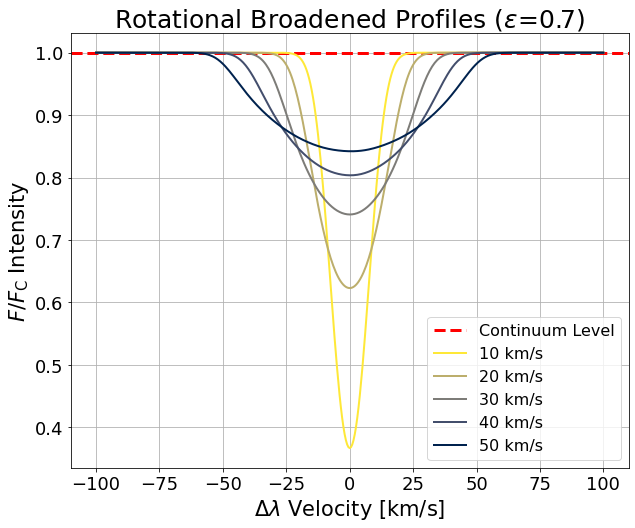

In [9]:
plt.figure(figsize=figsize)
plt.axhline(y=1, color='red', linestyle='--', label='Continuum Level', linewidth=3)

cmap = cm.get_cmap('cividis', flux_profiles.shape[0])
colors = cmap(np.linspace(1, 0, flux_profiles.shape[0]))

for i, j in zip(range(flux_profiles.shape[0]), vel_eq):
    plt.plot(velocityArray, flux_profiles[i], label=f'{j} km/s', linewidth=linesize, color=colors[i])

plt.fill_between(velocityArray, profile, 1, where=(profile >= 1), color='blue', alpha=0.3)

plt.title("Rotational Broadened Profiles ($\epsilon$=0.7)", fontsize=titlesize)
plt.xlabel("$\Delta \lambda$ Velocity [km/s]", fontsize=labelsize)
plt.ylabel("$F/F_{\mathrm{C}}$ Intensity", fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.legend(fontsize=legendsize, loc="lower right")
plt.grid(True)
plt.show()

In [10]:
figsize=(12, 10)
titlesize=29
labelsize=26
linesize=2
legendsize=20
ticksize=22

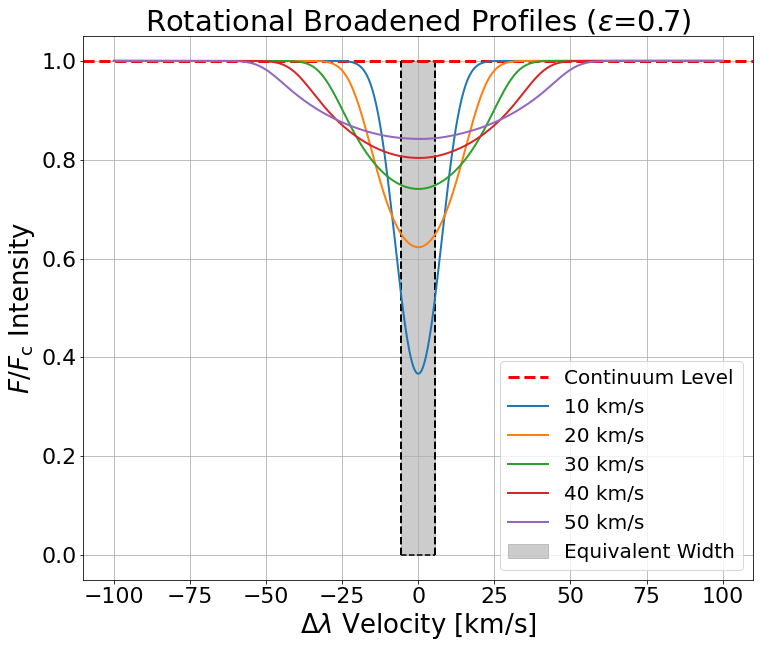

In [16]:
plt.figure(figsize=figsize)

eqw_pos = area/2
eqw_neg = -area/2
plt.plot([eqw_pos, eqw_pos], [0, 1], color='black', linestyle='--', linewidth=linesize)
plt.plot([eqw_neg, eqw_neg], [0, 1], color='black', linestyle='--', linewidth=linesize)
plt.plot([eqw_neg, eqw_pos], [0, 0], color='black', linestyle='--')
plt.plot([eqw_neg, eqw_pos], [1, 1], color='black', linestyle='--')
plt.fill_betweenx([0, 1], eqw_neg, eqw_pos, color='gray', alpha=0.4, label="Equivalent Width")

plt.axhline(y=1, color='red', linestyle='--', label='Continuum Level', linewidth=3)

for i, j in zip(range(flux_profiles.shape[0]), vel_eq):
    plt.plot(velocityArray, flux_profiles[i], label=f'{j} km/s', linewidth=linesize, color=f'C{i}')

plt.title("Rotational Broadened Profiles ($\epsilon$=0.7)", fontsize=titlesize)
plt.xlabel("$\Delta \lambda$ Velocity [km/s]", fontsize=labelsize)
plt.ylabel(r"$F/F_{\mathrm{c}}$ Intensity", fontsize=labelsize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.legend(fontsize=legendsize, loc="lower right")
plt.grid(True)

plt.savefig('Rotation_Broad_Spec.pdf')
plt.show()